## DPC Policy train

## 01. Prepare packages

In [121]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import pickle
from pickle import dump

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from scipy.optimize import minimize, Bounds
from scipy.stats import qmc
from torchmin import minimize as pytorch_minimize

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import os
print(os.listdir())

# import functions
import importlib
import DPC_Policy_cnn
importlib.reload(DPC_Policy_cnn)

from DPC_Policy_cnn import DPC_PolicyCNN, DPC_loss
from TiDE import TideModule, quantile_loss, TiDE_forward

if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")
    

['policy_model_CNN_case2.pth', 'README.md', 'DPC_Policy_dynamic.py', 'policy_model_5L_64H.pth', 'DPC_Policy_Train_dynamic.ipynb', 'policy_model_3L_128H.pth', '.git', 'policy_model_CNN_case1.pth', 'DPC_Policy_cnn.py', 'DPC_Policy_Train_cnn.ipynb', 'nominal_params_w10_mid_noise_stable_final.pkl', 'policy_model_3L_64H.pth', 'policy_parameters_basic_case3.pkl', 'DPC_Policy.py', 'policy_model_3L_32H.pth', 'nominal_params_w10_mid_noise_stable_final.pth', '__pycache__', 'all_policy_losses.pkl', 'DPC_Policy_Train.ipynb', 'policy_model_CNN_case3.pth', 'TiDE.py', 'all_policy_losses_CNN.pkl', 'x_and_u_and_c_case3.pickle', 'DPC_Main.ipynb', 'policy_model_5L_128H.pth', 'policy_parameters_basic_case3.pth']
cuda is available


## 02. System identification

In [122]:
t_tot = 50000
init_zero = 1000
def f_ss(x0,u):
    A = np.array([[0.3,0.1], [0.1, 0.2]])
    B = np.array([[0.5],[1.0]])
    mu = np.array([[0],[0]])*0
    w = np.array([[0.05],[0.1]])
    x = A@x0+B*u + np.random.normal(mu,w,size=(2,1))
    return x

def f_ss_multistep(x0,u):
    step = len(u)
    output = np.zeros([2,step])
    for i in range(step):
        x_next = f_ss(x0,u[i])
        x0 = np.copy(x_next)
        output[:,i] = x_next.reshape(-1)
    return output

tspan = [0, t_tot]
x0 = np.array([[0],[0]])
print(x0.shape)

(2, 1)


## 03-1. Data generation (Reference)

In [123]:
import numpy as np
import random
from scipy.special import expit 

def generate_u_seq():
    total_steps = t_tot * 2 

    init_zeros = np.zeros(1000)
    step_seq = []
    while len(step_seq) < t_tot:
        value = np.random.uniform(-5, 5)  
        duration = random.randint(5, 20) 
        step_seq.extend([value] * duration)
    step_seq = np.array(step_seq[:t_tot])  

    sin_seq = np.array([])
    while len(sin_seq) < t_tot:
        period = random.randint(10, 32) 
        duration = random.randint(10, 20)  
        x = np.linspace(0, 2 * np.pi, period)  
        amplitude = np.random.uniform(-5, 5) 
        segment = amplitude * np.sin(x)[:duration]  
        sin_seq = np.append(sin_seq, segment)
    sin_seq = sin_seq[:t_tot]
    u_seq = np.concatenate([init_zeros, step_seq, sin_seq])

    return u_seq

u_seq = generate_u_seq()
print(u_seq.shape)  

(101000,)


In [124]:
def dynamic_data_generator(x0, u_seq):
    step = len(u_seq)
    output = np.zeros([x0.shape[0], step])

    for i in range(step):
        u_max = 3 + 2 * np.random.random(1)
        u_min = -u_max
        x_next = f_ss(x0, u_seq[i]) 
        x0 = np.copy(x_next)

        output[:, i] = x_next.reshape(-1)

    return output, u_seq 
x_output, u_seq_new = dynamic_data_generator(x0,u_seq)

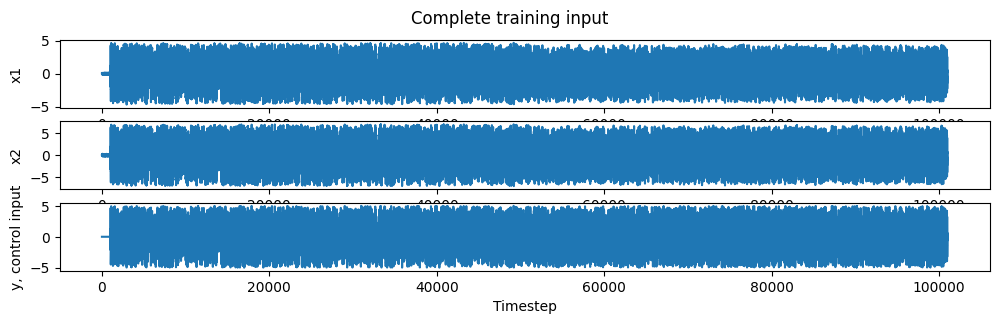

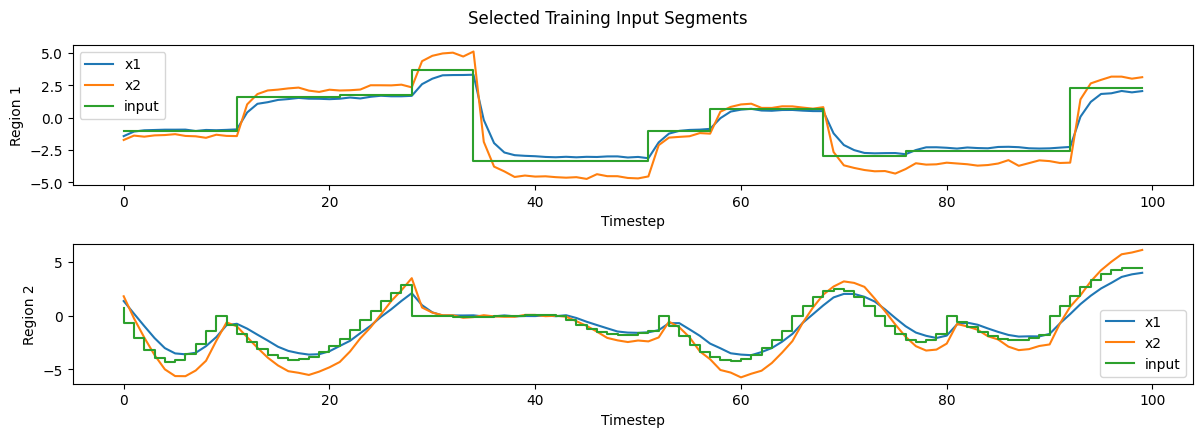

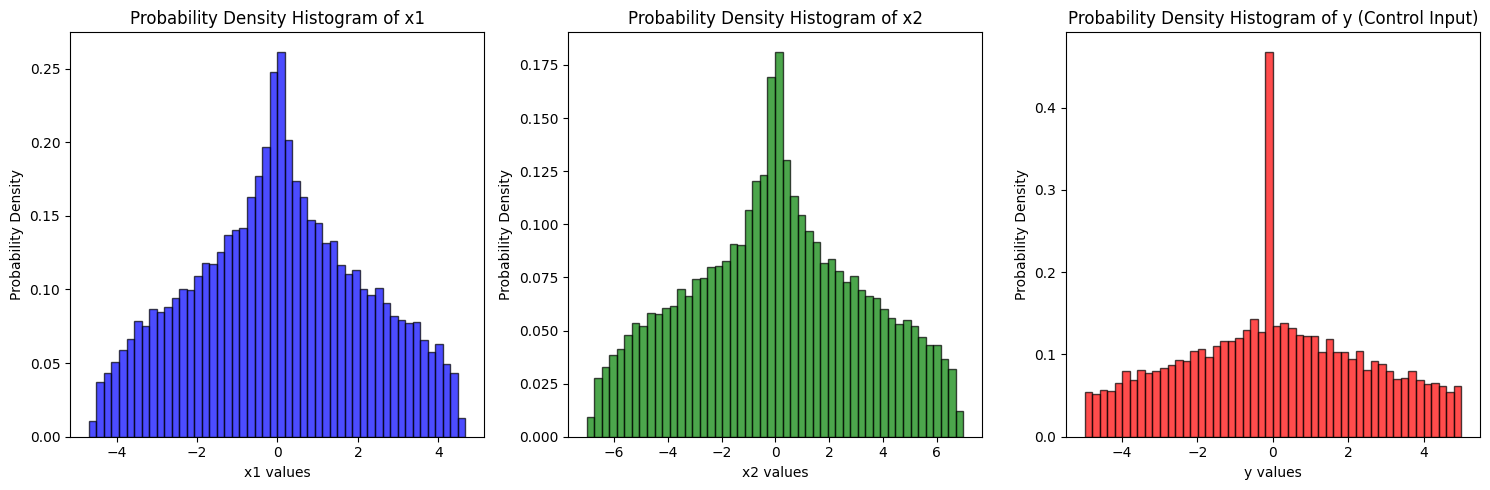

In [125]:
plt.figure(figsize=(12,3))
plt.suptitle("Complete training input")
plt.subplot(3,1,1)

plt.plot(x_output[0,:], label="x1")
plt.xlabel("x1, system response")
plt.ylabel("x1")
plt.subplot(3,1,2)

plt.plot(x_output[1,:],label="x2")
plt.xlabel("x2, system response")
plt.ylabel("x2")
plt.subplot(3,1,3)
plt.plot(u_seq, drawstyle='steps',label="input")
plt.xlabel("Timestep")
plt.ylabel("y, control input")

plt.show()

mm_list = [2000, t_tot + 2000] 
window_size = 100

plt.figure(figsize=(12, 6)) 

for idx, mm in enumerate(mm_list, 1):
    plt.subplot(3, 1, idx)
    plt.plot(x_output[0, mm:mm+window_size], label="x1")
    plt.plot(x_output[1, mm:mm+window_size], label="x2")
    plt.plot(u_seq[mm:mm+window_size], drawstyle='steps', label="input")

    plt.xlabel("Timestep")
    plt.ylabel(f"Region {idx}")  
    plt.legend()

plt.suptitle("Selected Training Input Segments")
plt.tight_layout()  
plt.show()

x1 = x_output[0, :]
x2 = x_output[1, :]
y = u_seq_new.flatten()  

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(x1, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title("Probability Density Histogram of x1")
axes[0].set_xlabel("x1 values")
axes[0].set_ylabel("Probability Density")

axes[1].hist(x2, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title("Probability Density Histogram of x2")
axes[1].set_xlabel("x2 values")
axes[1].set_ylabel("Probability Density")

axes[2].hist(y, bins=50, density=True, alpha=0.7, color='red', edgecolor='black')
axes[2].set_title("Probability Density Histogram of y (Control Input)")
axes[2].set_xlabel("y values")
axes[2].set_ylabel("Probability Density")

plt.tight_layout()
plt.show()

x = x_output
u = u_seq_new.reshape(1,-1)

## 03-2. Data generation (Constraint)

In [126]:
def generate_constraint_seq():
    init_fives = np.full(1000, 4)  
    step_seq = []
    while len(step_seq) < t_tot:
        value = np.random.uniform(2, 5) 
        duration = random.randint(20, 50) 
        step_seq.extend([value] * duration)
    step_seq = np.array(step_seq[:t_tot]) 

    sin_seq = np.array([])
    while len(sin_seq) < t_tot:
        period = random.randint(20, 50) 
        duration = random.randint(20, 50)  
        x = np.linspace(0, 2 * np.pi, period) 
        amplitude = np.random.uniform(0.5, 1) 
        center = np.random.uniform(3.5-0.5, 3.5+0.5)  
        segment = center + amplitude * np.sin(x)[:duration]  
        sin_seq = np.append(sin_seq, segment)
    sin_seq = sin_seq[:t_tot]  
    constraint_seq = np.concatenate([init_fives, step_seq, sin_seq])

    return constraint_seq

constraint_seq = generate_constraint_seq()
constraint_seq_2 = constraint_seq.reshape(1, -1)
c = np.vstack((-constraint_seq_2, constraint_seq_2))
print(c.shape)

(2, 101000)


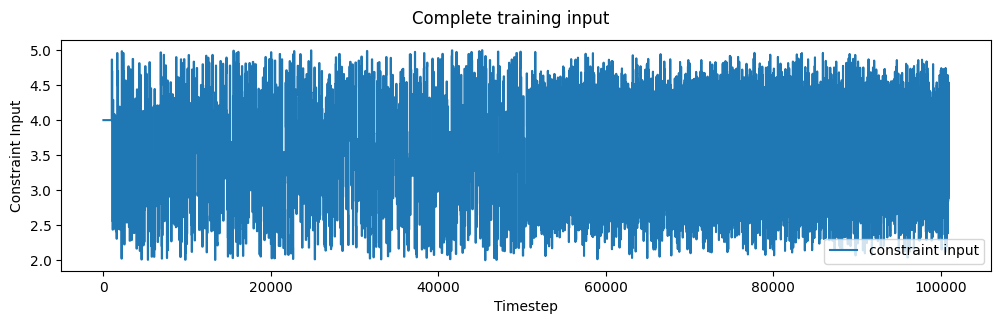

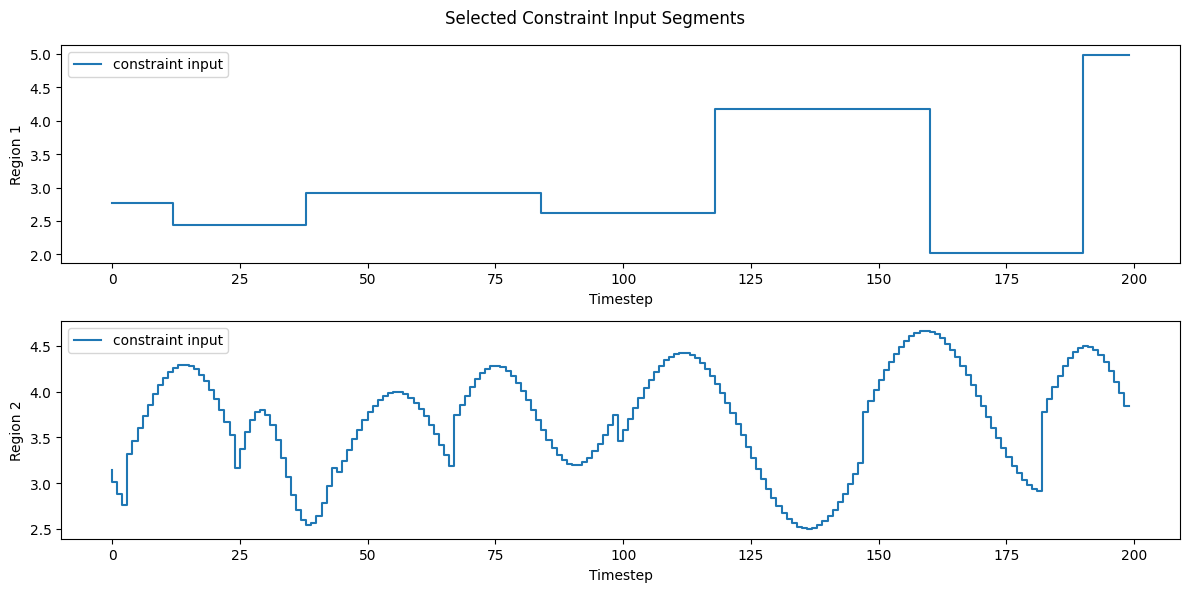

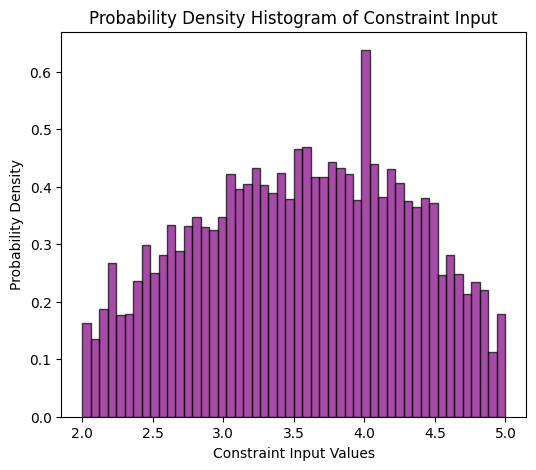

In [127]:
plt.figure(figsize=(12,3))
plt.suptitle("Complete training input")

plt.plot(constraint_seq, drawstyle='steps', label="constraint input")
plt.xlabel("Timestep")
plt.ylabel("Constraint Input")
plt.legend()
plt.show()

mm_list = [2000, t_tot + 2000]
window_size = 200

plt.figure(figsize=(12, 6))

for idx, mm in enumerate(mm_list, 1):
    plt.subplot(2, 1, idx)
    plt.plot(constraint_seq[mm:mm+window_size], drawstyle='steps', label="constraint input")
    plt.xlabel("Timestep")
    plt.ylabel(f"Region {idx}")
    plt.legend()

plt.suptitle("Selected Constraint Input Segments")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(constraint_seq, bins=50, density=True, alpha=0.7, color='purple', edgecolor='black')
ax.set_title("Probability Density Histogram of Constraint Input")
ax.set_xlabel("Constraint Input Values")
ax.set_ylabel("Probability Density")

plt.show()

In [128]:
import torch
import numpy as np

num_trials = 1000
sample_size = 1000 

device = "cuda" if torch.cuda.is_available() else "cpu"
difference_results = torch.zeros(num_trials, sample_size, device=device)
comparison_results = torch.zeros(num_trials, sample_size, device=device)  

x2 = torch.as_tensor(x2, dtype=torch.float32, device=device)
constraint_seq = torch.as_tensor(constraint_seq, dtype=torch.float32, device=device)

for i in range(num_trials):
    x2_positive = x2[x2 > 0] 
    if len(x2_positive) < sample_size:  
        raise ValueError("Not enough samples in x2_positive!")

    x2_sample = x2_positive[torch.randint(0, len(x2_positive), (sample_size,), device=device)]
    constraint_sample = constraint_seq[torch.randint(0, len(constraint_seq), (sample_size,), device=device)]
    comparison = (x2_sample > constraint_sample).to(torch.float)  
    difference = torch.clamp(x2_sample - constraint_sample, min=0) ** 2  

    comparison_results[i] = comparison
    difference_results[i] = difference

probability = comparison_results.mean().item()  
average_difference = difference_results.mean().item()  

print(f"✅ Probability of x2 > constraint_seq: {probability:.4f}")
print(f"✅ Mean squared difference (when x2 is greater than constraint_seq): {average_difference:.4f}")

✅ Probability of x2 > constraint_seq: 0.3275
✅ Mean squared difference (when x2 is greater than constraint_seq): 1.1278


## 03. Save x, u to a single pickle file

In [129]:
import pickle
data = {'x': x, 'u': u, 'c': c}

pickle_filename = 'x_and_u_and_c_case3.pickle'

with open(pickle_filename, 'wb') as f:
    pickle.dump(data, f)

print(f"Saved 'x' and 'u' arrays to {pickle_filename}")
pickle_filename = 'x_and_u_and_c_case3.pickle'

with open(pickle_filename, 'rb') as f:
    loaded_data = pickle.load(f)

x = loaded_data['x']
u = loaded_data['u']
c = loaded_data['c']

print("Loaded 'x' array shape:", x.shape)
print("Loaded 'u' array shape:", u.shape)
print("Loaded 'c' array shape:", c.shape)

Saved 'x' and 'u' arrays to x_and_u_and_c_case3.pickle
Loaded 'x' array shape: (2, 101000)
Loaded 'u' array shape: (1, 101000)
Loaded 'c' array shape: (2, 101000)


## 04. Normalize data

In [130]:
window = 10
P = 10

def normalize_array(arr, ref_arr=None):
    """
    Normalize 'arr' to the range [-1, 1] using min/max values.
    If ref_arr is provided, normalize based on ref_arr's min/max values.
    """
    if ref_arr is None:
        ref_arr = arr  

    min_val = np.min(ref_arr, axis=1, keepdims=True)  
    max_val = np.max(ref_arr, axis=1, keepdims=True)  
    diff = max_val - min_val 
    diff[diff == 0] = 1  

    print("Normalization Diff:", diff)

    normalized_arr = -1 + 2 * ((arr - min_val) / diff)
    return normalized_arr

x_normalized = normalize_array(x)
u_normalized = normalize_array(u)
c_normalized = normalize_array(c, ref_arr=np.tile(x[1, :], (2, 1)))  

print("x_normalized shape:", x_normalized.shape)
print("u_normalized shape:", u_normalized.shape)
print("c_normalized shape:", c_normalized.shape)

Xs = u_normalized.reshape(-1,1)
Ys = x_normalized.transpose()
Cs = c_normalized.transpose()

print(Xs.shape) # CONTROL
print(Ys.shape) # STATE
print(Cs.shape) # CONSTRAINTS


val_indices = [
    (1000, int(1000 + 0.1 * t_tot)),
    (t_tot + 1000, int(t_tot + 1000 + 0.1 * t_tot))
]

Xs_train = []
Ys_train = []
Cs_train = []
Xs_val = []
Ys_val = []
Cs_val = []


for i in range(Xs.shape[0]):  
    is_val = any(start <= i < end for start, end in val_indices)

    if is_val:
        Xs_val.append(Xs[i])
        Ys_val.append(Ys[i])
        Cs_val.append(Cs[i])
    else:
        Xs_train.append(Xs[i])
        Ys_train.append(Ys[i])
        Cs_train.append(Cs[i])

Xs_train = np.array(Xs_train)
Ys_train = np.array(Ys_train)
Cs_train = np.array(Cs_train)
Xs_val = np.array(Xs_val)
Ys_val = np.array(Ys_val)
Cs_val = np.array(Cs_val)

model_params = dict()
model_params["x_min"] = np.min(x, axis=1)
model_params["x_max"] = np.max(x, axis=1)
model_params["u_min"] = np.min(u, axis=1)
model_params["u_max"] = np.max(u, axis=1)
model_params["c_min"] = np.min(c, axis=1)
model_params["c_max"] = np.max(c, axis=1)
model_params["window"] = window
model_params["P"] = P

print(Xs_train.shape)
print(Xs_val.shape)

print(Cs_train.shape)
print(Cs_val.shape)

print(f"Xs (normalized u sequence) shape = {Xs.shape}, Ys (normalized x1-x2 sequence) shape = {Ys.shape}, Cs (normalized x1-x2 sequence) shape = {Cs.shape}")

Normalization Diff: [[ 9.35908577]
 [14.00807709]]
Normalization Diff: [[9.98873229]]
Normalization Diff: [[14.00807709]
 [14.00807709]]
x_normalized shape: (2, 101000)
u_normalized shape: (1, 101000)
c_normalized shape: (2, 101000)
(101000, 1)
(101000, 2)
(101000, 2)
(91000, 1)
(10000, 1)
(91000, 2)
(10000, 2)
Xs (normalized u sequence) shape = (101000, 1), Ys (normalized x1-x2 sequence) shape = (101000, 2), Cs (normalized x1-x2 sequence) shape = (101000, 2)


## 05. Split data

In [131]:
X_train = [] 
X_train_past = [] 
Y_train = [] 
C_train = []

for i in range(window, len(Xs_train)-P):
    X_train.append((Ys_train[i-window:i+P,:])) 
    Ys_train_add = np.copy(Xs_train[i-window:i,:]) 
    X_train_past.append(Ys_train_add) 
    Y_train.append(Xs_train[i:i+P,:]) 

X_val = []
X_val_past = []
Y_val = []

for i in range(window, len(Xs_val)-P):

    X_val.append(Ys_val[i-window:i+P,:])
    Ys_val_add = np.copy(Xs_val[i-window:i,:])
    X_val_past.append(Ys_val_add)
    Y_val.append(Xs_val[i:i+P,:])

X_train_array = np.array(X_train)
print(f' X_train shape = {X_train_array.shape}')
X_train_past = np.array(X_train_past)
print(f' X_train_past shape = {X_train_past.shape}')
Y_train_array = np.array(Y_train)
print(f' Y_train shape = {Y_train_array.shape}')


X_train_array = np.array(X_train)
X_train_orig = torch.tensor(X_train_array).type(torch.float32).to(device)                                 
X_train_past_orig = torch.tensor(np.array(X_train_past)).type(torch.float32).to(device)              
Y_train_orig = torch.tensor(np.array(Y_train)).type(torch.float32).to(device)                        

print(X_train_array.shape)
print(X_train_orig.shape)
print(X_train_past_orig.shape)
print(Y_train_orig.shape)

X_val_array = np.array(X_val)
X_val_orig = torch.tensor(X_val_array).type(torch.float32).to(device)                                 
X_val_past_orig = torch.tensor(np.array(X_val_past)).type(torch.float32).to(device)               
Y_val_orig = torch.tensor(np.array(Y_val)).type(torch.float32).to(device)                      

X_past = torch.cat([X_train_past_orig[:,:],X_train_orig[:,:window]],dim=2)
X_future_covariates = X_train_orig[:,-P:,:]

x_in = [X_past, X_future_covariates, None]
Y_in = Y_train_orig[:,:,:].to(device) 

X_past_val = torch.cat([X_val_past_orig[:,:],X_val_orig[:,:window,:]],dim=2)
X_future_covariates_val = X_val_orig[:,-P:,:]

C_fut = []
for i in range(len(Cs_train) - window - P):
    segment = Cs_train[i:i+window]  
    C_fut.append(segment)

c_fut = np.array(C_fut) 
C_fut = torch.tensor(C_fut, dtype=torch.float32).to(device) 


C_fut_val = []
for i in range(len(Cs_val) - window - P):
    segment = Cs_val[i:i+window]  
    C_fut_val.append(segment)

C_fut_val = np.array(C_fut_val)  
C_fut_val = torch.tensor(C_fut_val, dtype=torch.float32).to(device)  

x_val = [X_past_val, X_future_covariates_val[:,:,0], C_fut_val, None] 
Y_val = Y_val_orig[:,:,:].to(device)            

print(f"c_fut shape = {C_fut.shape}")  
print(f"c_fut_val shape = {C_fut_val.shape}")  


print(f"x_past shape = {X_past.shape}, x_future_covariate shape = {X_future_covariates.shape}, target shape = {Y_in.shape}")
print(f"x_past_val shape = {X_past_val.shape}, x_future_covariate_val shape = {X_future_covariates_val.shape}, target_val shape = {Y_val.shape}")        # Validation output

 X_train shape = (90980, 20, 2)
 X_train_past shape = (90980, 10, 1)
 Y_train shape = (90980, 10, 1)
(90980, 20, 2)
torch.Size([90980, 20, 2])
torch.Size([90980, 10, 1])
torch.Size([90980, 10, 1])
c_fut shape = torch.Size([90980, 10, 2])
c_fut_val shape = torch.Size([9980, 10, 2])
x_past shape = torch.Size([90980, 10, 3]), x_future_covariate shape = torch.Size([90980, 10, 2]), target shape = torch.Size([90980, 10, 1])
x_past_val shape = torch.Size([9980, 10, 3]), x_future_covariate_val shape = torch.Size([9980, 10, 2]), target_val shape = torch.Size([9980, 10, 1])


## 06. NN Policy Model (build, train)

In [132]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

num_epoch = 100

def train_and_evaluate(config):
    setting_name = config["name"]
    n_layers = config["n_layers"]
    kernel_size = config["kernel_size"]

    model = DPC_PolicyCNN(
        input_channels=6,
        output_dim=1,
        output_chunk_length=P,
        n_layers=n_layers,
        kernel_size=kernel_size
    ).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    train_dataset = TensorDataset(X_past, X_future_covariates, Y_in, C_fut)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    best_model = None
    best_val_loss = float("inf")
    save_train_loss = np.zeros(num_epoch)
    save_val_loss = np.zeros(num_epoch)
    patience = 50
    counter = 0

    val_tracking_losses = []
    val_smoothness_losses = []
    val_constraint_losses = []

    with tqdm(total=num_epoch, desc=f"{setting_name}") as pbar:
        for epoch in range(num_epoch):
            for x_past, x_future_cov, y_in, c_fut in train_loader:
                c_fut_single = c_fut[:, :, 0:1]

                x_past, x_future_cov, c_fut_single = x_past.to(device), x_future_cov.to(device), c_fut_single.to(device)
                x_in = [x_past, x_future_cov, c_fut_single, None]

                model.train()
                optimizer.zero_grad()

                policy_output = model(x_in).squeeze(-1)  # [B, 10, 1]
                x_in_t = (x_past, policy_output, None)
                tide_output = nominal_TiDE(x_in_t)

                loss = DPC_loss(tide_output, x_future_cov, policy_output, c_fut)
                loss.backward()
                optimizer.step()

            model.eval()
            c_val_single = C_fut_val[:, :, 0:1]
            x_val_input = [X_past_val, X_future_covariates_val, c_val_single, None]

            val_out = model(x_val_input).squeeze(-1)
            tide_output_val = nominal_TiDE([X_past_val, val_out, None])

            val_loss, track_loss, smooth_loss, constraint_loss = DPC_loss(
                tide_output_val, X_future_covariates_val, val_out, C_fut_val, return_all=True
            )

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            save_train_loss[epoch] = loss.item()
            save_val_loss[epoch] = val_loss

            val_tracking_losses.append(track_loss)
            val_smoothness_losses.append(smooth_loss)
            val_constraint_losses.append(constraint_loss)

            scheduler.step()
            pbar.set_description(f"{setting_name} | Epoch {epoch} | Train: {loss.item():.4f} | Val: {val_loss:.4f}")
            pbar.update(1)

    # 모델 저장
    torch.save(best_model, f"policy_model_{setting_name}.pth")

    return {
        "train_loss": save_train_loss,
        "val_loss": save_val_loss,
        "val_tracking": val_tracking_losses,
        "val_smoothness": val_smoothness_losses,
        "val_constraint": val_constraint_losses
    }



In [133]:
with open('nominal_params_w10_mid_noise_stable_final.pkl', 'rb') as file: 
    nominal_params = pickle.load(file)
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_mid_noise_stable_final.pth'))
nominal_TiDE.eval()
window = 10

nominal_TiDE = nominal_TiDE.to(device)

In [134]:
import pickle
from tqdm import tqdm

# CNN 실험 config: layer 수와 kernel size 조합
experiment_configs = [
    {"name": "cnn_L2_K3", "n_layers": 2, "kernel_size": 3},
    {"name": "cnn_L3_K3", "n_layers": 3, "kernel_size": 3},
    {"name": "cnn_L4_K3", "n_layers": 4, "kernel_size": 3},
    {"name": "cnn_L3_K5", "n_layers": 3, "kernel_size": 5},
    {"name": "cnn_L4_K5", "n_layers": 4, "kernel_size": 5},
]

results = {}

for config in tqdm(experiment_configs):
    result = train_and_evaluate(config)
    results[config["name"]] = result

# 결과 저장
with open("all_policy_losses_dynamicCNN.pkl", "wb") as f:
    pickle.dump(results, f)


cnn_L2_K3 | Epoch 99 | Train: 0.1701 | Val: 0.1894: 100%|██████████| 100/100 [04:05<00:00,  2.46s/it]
cnn_L3_K3 | Epoch 99 | Train: 0.1588 | Val: 0.1871: 100%|██████████| 100/100 [04:16<00:00,  2.56s/it]
cnn_L4_K3 | Epoch 99 | Train: 0.1767 | Val: 0.1875: 100%|██████████| 100/100 [04:20<00:00,  2.61s/it]
cnn_L3_K5 | Epoch 99 | Train: 0.1712 | Val: 0.1890: 100%|██████████| 100/100 [04:12<00:00,  2.53s/it]
cnn_L4_K5 | Epoch 99 | Train: 0.1707 | Val: 0.1883: 100%|██████████| 100/100 [04:22<00:00,  2.63s/it]
100%|██████████| 5/5 [21:17<00:00, 255.59s/it]


## 08. Loss history

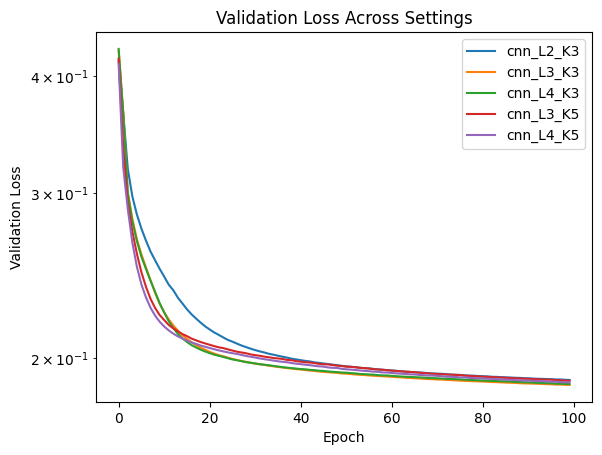

In [135]:
import matplotlib.pyplot as plt

for key in results:
    plt.plot(results[key]['val_loss'], label=f"{key}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.yscale("log")
plt.legend()
plt.title("Validation Loss Across Settings")
plt.show()


In [137]:
import pickle

# 저장된 실험 결과 불러오기
with open("all_policy_losses_CNN.pkl", "rb") as f:
    results = pickle.load(f)

# 요약 비교 테이블 생성
summary = []

for config, data in results.items():
    best_epoch = np.argmin(data["val_loss"])
    summary.append({
        "config": config,
        "best_val_loss": data["val_loss"][best_epoch],
        "tracking": data["val_tracking"][best_epoch],
        "smoothness": data["val_smoothness"][best_epoch],
        "constraint": data["val_constraint"][best_epoch]
    })

# pandas DataFrame으로 정리 및 정렬
import pandas as pd
df = pd.DataFrame(summary)
df_sorted = df.sort_values("best_val_loss")

# 결과 출력
pd.set_option("display.precision", 5)
print(df_sorted)


      config  best_val_loss  tracking  smoothness  constraint
0  CNN_case1        0.20889   0.17736     0.00701     0.02452
1  CNN_case2        0.21649   0.18243     0.00658     0.02748
2  CNN_case3        0.21755   0.18155     0.00666     0.02933
